## Preparing the target distribution of the MCMC Algorithms

Preparing the dataset of Gaussian Mixture Model with 2 components.  

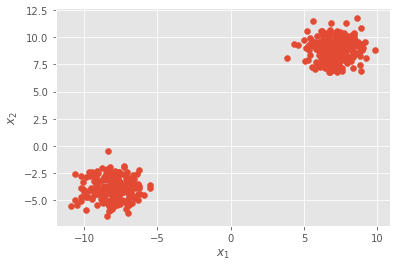

In [14]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.GMM_datagen import Data_params_gen_GMM
import matplotlib.pyplot as plt

GMM_data_2D_2com = Data_params_gen_GMM(n_components=2, n_dimensions=2)
_,_ = GMM_data_2D_2com.generate(datasize=500)

with plt.style.context("ggplot"):
    plt.scatter(GMM_data_2D_2com.noisy_Dataset[:, 0], GMM_data_2D_2com.noisy_Dataset[:, 1])
    plt.xlabel("$x_1$")

    plt.ylabel("$x_2$")
    plt.show()

Defining the Likelihood function with the dataset generated above.  

In [15]:
from MCMC_DianZhang.Dian_BayesianInference.Dian_BayesianInference.log_Likeli_GMM import Likeli_GMM_mus

GMM_Likeli_2D_2com = Likeli_GMM_mus(Dataset=GMM_data_2D_2com.noisy_Dataset, Sigmas=GMM_data_2D_2com.Sigmas, weights=GMM_data_2D_2com.weights, n_components=GMM_data_2D_2com.n_components)

## Apply the MCMC Algorithm

In [16]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.MHMC import MHMC
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import  GaussianProposalDistribution
steps = 100000
Prop_G = GaussianProposalDistribution(sd=0.10, Dim=GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)
MHMC_GMM_2D_2com = MHMC(rho=GMM_Likeli_2D_2com.calculate_log_likelihoods, log_likelihood=True)
Res_G = MHMC_GMM_2D_2com.generate(
    theta0=[0 for _ in range(GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)], 
    qProb=Prop_G.log_qProb, 
    qSamp=Prop_G.qSample, 
    steps=steps,
    OutputRunTime=100,
    MaxTime=7
    )

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/MetropolisHastingMCMC/MHMC.py:83: RuntimeWarning: overflow encountered in exp
  alpha = min(1, np.exp(self.rho(theta_1) + (qProb(theta_1, theta_0)) - (self.rho(theta_0) + (qProb(theta_0, theta_1)))))


In [17]:
from MCMC_DianZhang.Dian_MCMC.MetropolisHastingMCMC.ProposalDistributions import HamiltonianProposalFunction, HamiltonianProposalFunction_vec

Prop_H = HamiltonianProposalFunction(rho = GMM_Likeli_2D_2com.calculate_log_likelihoods, epsilon=0.01, L=5, log_likelihood=True)
MHMC_GMM_2D_2com_H = MHMC(rho=Prop_H.U, log_likelihood=True)
Res_H = MHMC_GMM_2D_2com_H.generate(
    theta0=[0.0 for _ in range(GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)], 
    qProb=Prop_H.log_qProb, 
    qSamp=Prop_H.qSample, 
    steps=steps,
    OutputRunTime=100,
    MaxTime=7
)


In [18]:
Prop_H_MT = HamiltonianProposalFunction_vec(rho = GMM_Likeli_2D_2com.calculate_log_likelihoods, epsilon=0.01, L=5, log_likelihood=True)
MHMC_GMM_2D_2com_H = MHMC(rho=Prop_H_MT.U, log_likelihood=True)
Res_H_MT = MHMC_GMM_2D_2com_H.generate(
    theta0=[0.0 for _ in range(GMM_Likeli_2D_2com.n_dimensions*GMM_Likeli_2D_2com.n_components)], 
    qProb=Prop_H_MT.log_qProb, 
    qSamp=Prop_H_MT.qSample, 
    steps=steps,
    OutputRunTime=100,
    MaxTime=7
)


## Visualize the output of the MCMC Algorithm

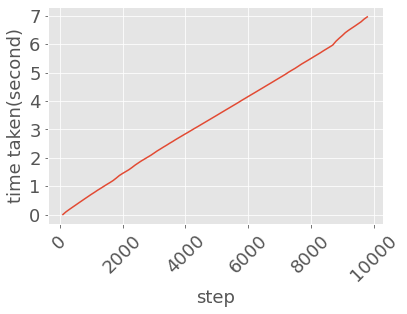

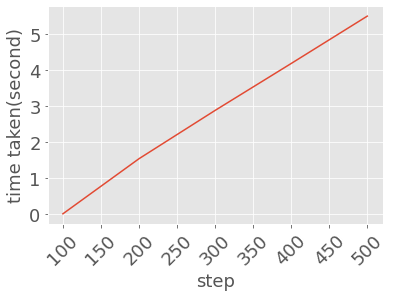

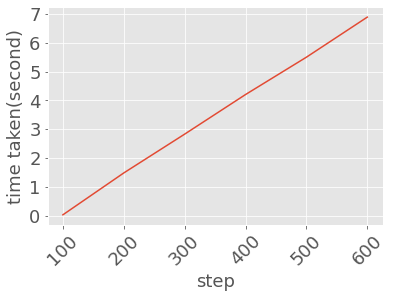

In [19]:
for Res in [Res_G, Res_H, Res_H_MT]:
    with plt.style.context("ggplot"):
        plt.plot([100*i for i in range(1, len(Res["Run_Times"])+1)], Res["Run_Times"])
        plt.ylabel("time taken(second)", fontsize=18)
        plt.yticks(fontsize=18)
        plt.xticks(rotation=45)
        plt.xlabel("step", fontsize=18)
        plt.xticks(fontsize=18)
        plt.show()

The acceptance rate of the MCMC algorithm = 0.206


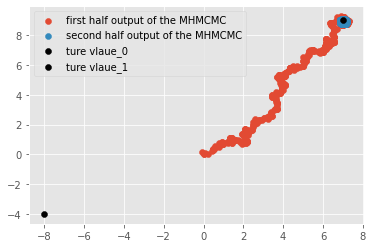

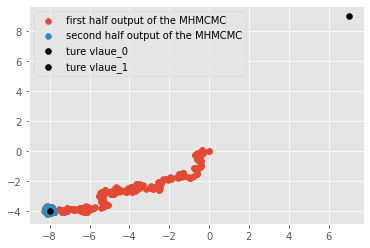

The acceptance rate of the MCMC algorithm = 0.982


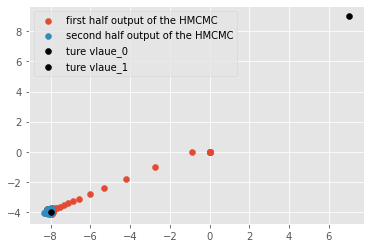

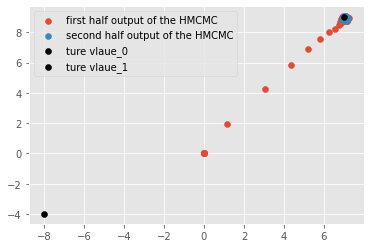

The acceptance rate of the MCMC algorithm = 0.996


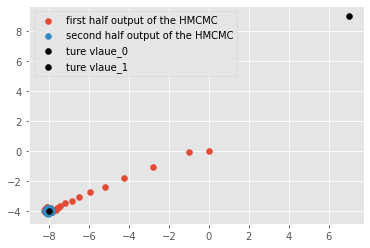

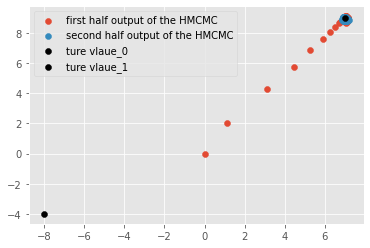

In [23]:
import numpy as np

for Res, MC_name in zip([Res_G, Res_H, Res_H_MT], ["MHMCMC", "HMCMC", "HMCMC"]):
    print(f"The acceptance rate of the MCMC algorithm = {Res['Acceptance_Rate']:.3f}")
    steps = Res["Thetas"].shape[0]
    with plt.style.context("ggplot"):
        for i in range(GMM_Likeli_2D_2com.n_components):
            plt.scatter(Res["Thetas"][:steps//2, i*2], Res["Thetas"][:steps//2, i*2+1], label=f"first half output of the {MC_name}")
            plt.scatter(Res["Thetas"][steps//2:, i*2], Res["Thetas"][steps//2:, i*2+1], label=f"second half output of the {MC_name}")

            for j in range(GMM_Likeli_2D_2com.n_components):
                plt.scatter(GMM_data_2D_2com.mus[j][0], GMM_data_2D_2com.mus[j][1], label=f"ture vlaue_{j}", color="black")
            plt.legend()
            plt.show()

In [22]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import density_plot_3D
Res = Res_G

for cr in [0, 0.3, 0.9]:
    density_plot_3D(Res["Thetas"], bins=50, burn_in=2500, credible_region=cr)

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/Statistic_tools.py:225: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



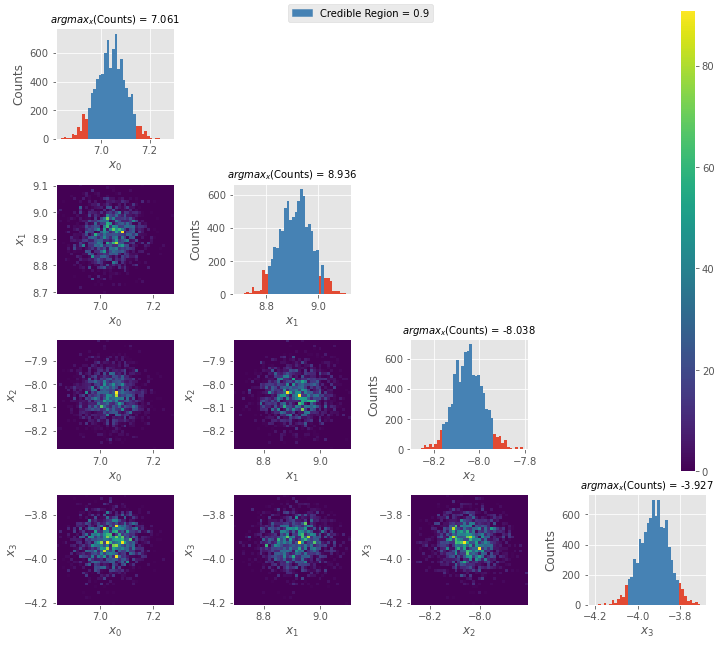

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/Statistic_tools.py:225: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



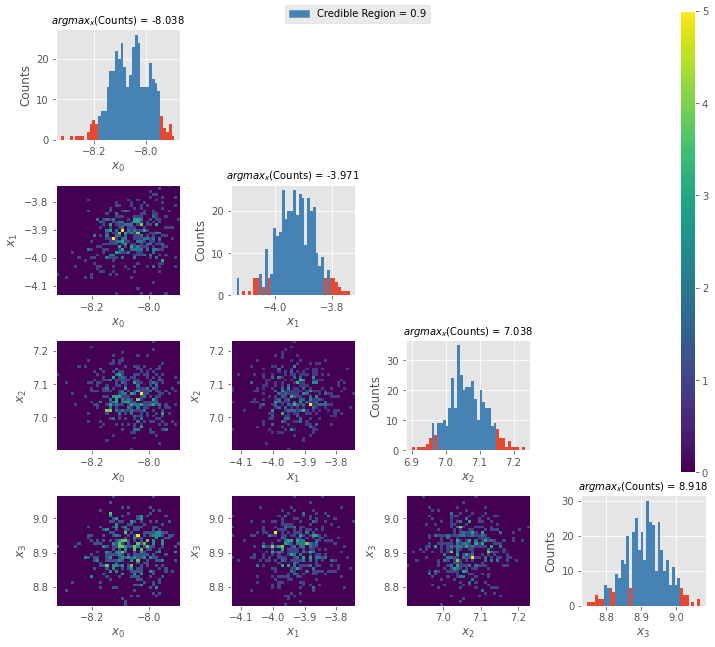

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DianZhang/Dian_MCMC/Statistic_tools.py:225: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



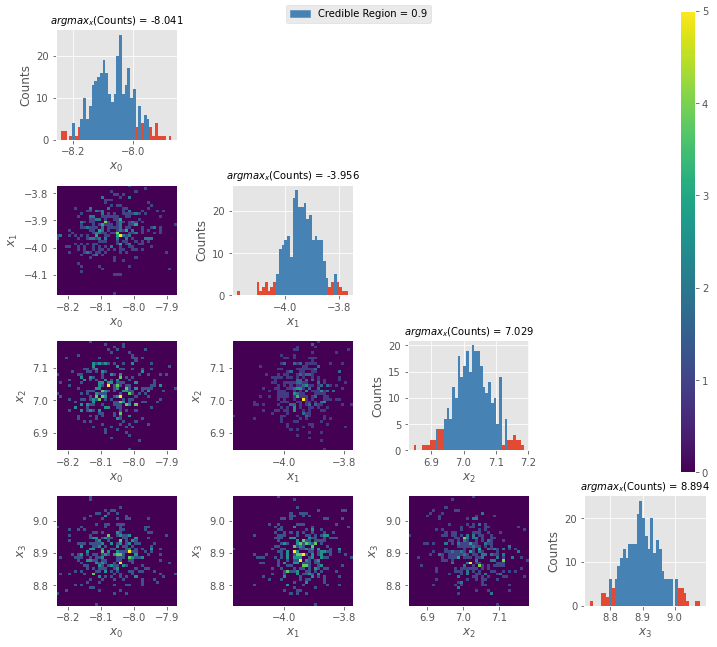

In [27]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import densities_plot

for bi, Res in zip([1000, 100, 200], [Res_G, Res_H, Res_H_MT]):
    _ = densities_plot(Thetas=Res["Thetas"], plot_axis=[], bins=40, burn_in=bi, cr_1D=0.9)

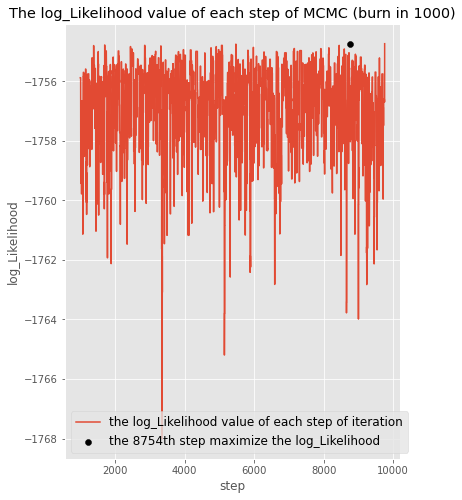

In [33]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import targetDis_step_plot

for Res in [Res_G, Res_H, Res_H_MT]:
    targetDis_step_plot(Thetas=Res["Thetas"], rho=GMM_Likeli_2D_2com.calculate_log_likelihoods, target_type="log_Likelihood", return_maximum=True, burn_in=1000)
    break

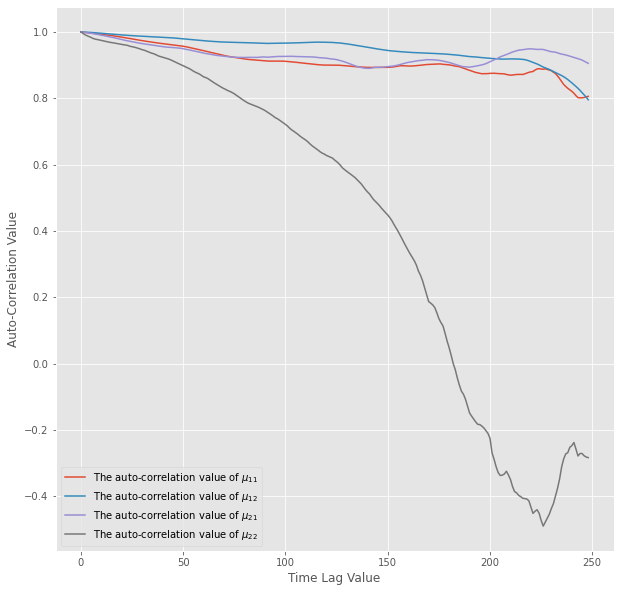

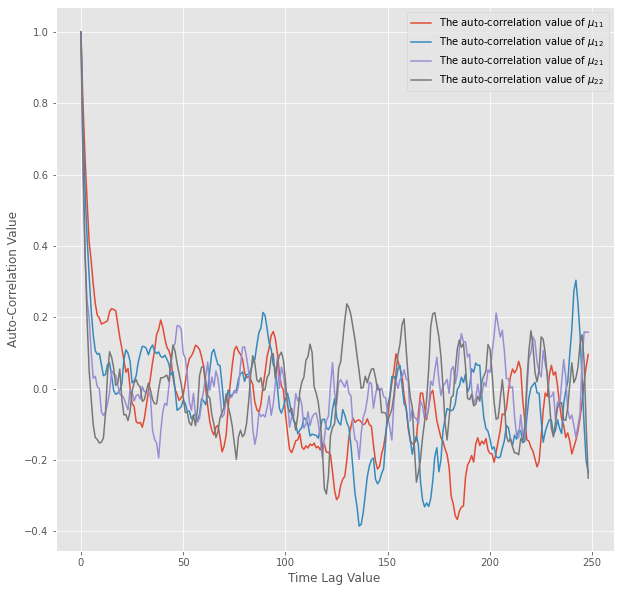

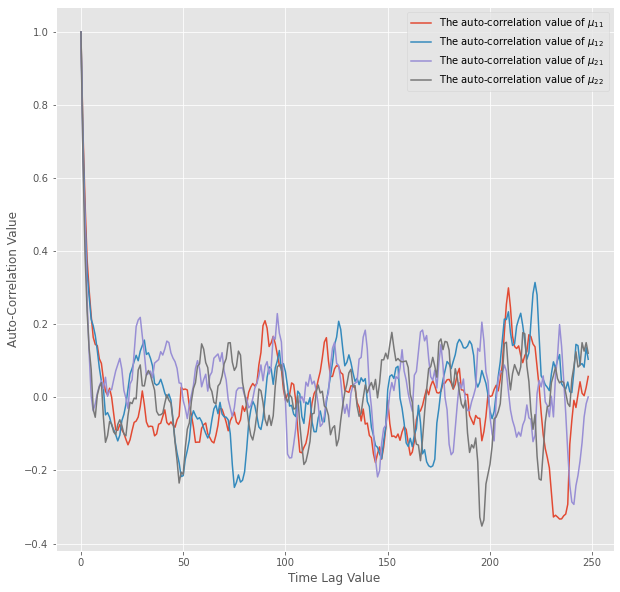

In [37]:
from MCMC_DianZhang.Dian_MCMC.Statistic_tools import auto_corr_plot

for Res in [Res_G, Res_H, Res_H_MT]:
    auto_corr_plot(Thetas=Res["Thetas"], plot_nth_theta=[0,1,2,3], theta_index=["$\mu_{11}$", "$\mu_{12}$", "$\mu_{21}$", "$\mu_{22}$"], max_time_lag=250, data_range=[99,499])

In [1]:
import numpy as np
from MCMC_DianZhang.Dian_BayesianInference.Dian_Likelihood_functions.Periodic_Function import Periodic_Func2D

PF  = Periodic_Func2D([2,3], [[0,1], [0,1]])
Func = PF.f
Func_name = "2D Periodic Function"

X_range = [-1, 2]
Y_range = [-1, 2]

import plotly.graph_objects as go
# Define thei grid 
X_val = np.linspace(X_range[0], X_range[1], 100)
Y_val = np.linspace(Y_range[0], Y_range[1], 100)
X_grid, Y_grid = np.meshgrid(X_val, Y_val)

# Compute the values of the z-axis
Z_grid = Func(np.column_stack((X_grid.flatten(), Y_grid.flatten())))
Z_grid = Z_grid.reshape(X_grid.shape)

# Create the surface plot
fig = go.Figure(data = [go.Surface(x=X_grid, y=Y_grid, z=Z_grid)])

# Set the plot title and axis labels
fig.update_layout(
    title = Func_name,
    scene = dict(
        xaxis_title = "X",
        yaxis_title = "Y",
        zaxis_title = "f(X, Y)",
    )
)

fig.show()